/tmp/ipykernel_351117/3232537534.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_filtered["cluster"] = clustering2.labels_


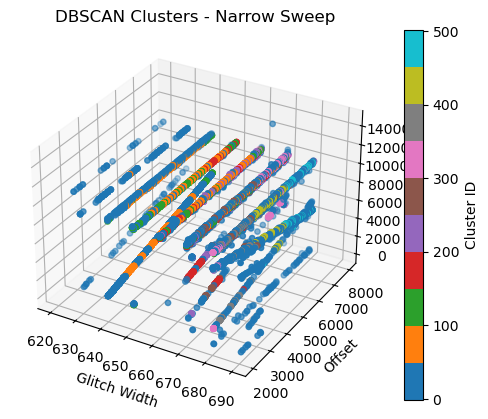

(        glitch_width                        offset                            \
                count        mean        std  count         mean          std   
 cluster                                                                        
 -1              3450  671.136232  14.377445   3450  5088.205797  1728.354885   
  0                 5  630.000000   0.000000      5  2000.000000     0.000000   
  1                93  640.860215   3.506489     93  2067.204301    46.796637   
  2                85  639.764706   1.524772     85  2236.823529    45.361295   
  3                78  639.743590   1.590850     78  2395.512821    49.534127   
 
         retval                            
          count         mean          std  
 cluster                                   
 -1        3450  7606.553623  2518.731957  
  0           5  9702.000000     0.000000  
  1          93  1781.935484     0.437544  
  2          85  1880.952941     0.263036  
  3          78  1979.961538     0.193552 

In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN




# Load new dataset
path2 = "/home/user/Desktop/loopmp2narrow.txt"
with open(path2, "r") as f:
    data2 = f.read()

# Extract the tuples again
matches2 = re.findall(r"\((\d+),\s*(\d+),\s*'r(\d+)'\)", data2)
df2 = pd.DataFrame(matches2, columns=["glitch_width", "offset", "retval"]).astype(int)

# Filter out obvious outliers
df2_filtered = df2[df2["retval"] < 1_000_000]

# DBSCAN clustering again
clustering2 = DBSCAN(eps=10, min_samples=5).fit(df2_filtered[["glitch_width", "offset", "retval"]])
df2_filtered["cluster"] = clustering2.labels_

# Plot 3D scatter of clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df2_filtered["glitch_width"], df2_filtered["offset"], df2_filtered["retval"],
                c=df2_filtered["cluster"], cmap="tab10", s=15)
ax.set_xlabel("Glitch Width")
ax.set_ylabel("Offset")
ax.set_zlabel("Return Value")
plt.colorbar(sc, label="Cluster ID")
plt.title("DBSCAN Clusters - Narrow Sweep")
plt.show()

# Cluster summary
summary2 = df2_filtered.groupby("cluster").agg(["count", "mean", "std"])

# Look for high-stability clusters (low std in retval)
stable_clusters = summary2[("retval", "std")].nsmallest(3)

# Find transition region: mixed clusters near each other
transition_candidates = df2_filtered.groupby(["glitch_width", "offset"])["cluster"].nunique()
transition_zone = transition_candidates[transition_candidates > 1]

(summary2.head(), stable_clusters, transition_zone.head())


In [1]:
import sys
print(sys.executable)




/home/user/anaconda3/bin/python


In [14]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import plotly.express as px
import plotly.io as pio
from IPython import get_ipython

# Pick a safe default for most Jupyter installs
pio.renderers.default = "plotly_mimetype"
pio.renderers.default = "iframe_connected"
pio.renderers.default = "browser"  

# ---- Load your file: update the path if needed ----
path = "/home/user/Desktop/loopmp2narrow.txt"  # or "mp2countingloop.txt"
with open(path, "r") as f:
    raw = f.read()

# Extract tuples like: (glitch_width, offset, 'rXXXX')
rows = re.findall(r"\((\d+),\s*(\d+),\s*'r(\d+)'\)", raw)
df = pd.DataFrame(rows, columns=["glitch_width", "offset", "retval"]).astype(int)

# Filter obvious outliers (keeps plot usable)
df = df[df["retval"] < 1_000_000].copy()

# ---- Run DBSCAN (tune eps/min_samples if needed) ----
X = df[["glitch_width", "offset", "retval"]].to_numpy()
clu = DBSCAN(eps=10, min_samples=5).fit(X)
df["cluster"] = clu.labels_.astype(int).astype(str)  # as string for nicer legend

# Optional: name the noise cluster
df.loc[df["cluster"] == "-1", "cluster"] = "noise"

# ---- Interactive 3D scatter ----
fig = px.scatter_3d(
    df,
    x="glitch_width",
    y="offset",
    z="retval",
    color="cluster",
    opacity=0.8,
    height=650,
    hover_data={
        "glitch_width": True,
        "offset": True,
        "retval": True,
        "cluster": True
    },
    title="DBSCAN clusters (interactive 3D)"
)

# Nice axis labels
fig.update_layout(
    scene=dict(
        xaxis_title="Glitch width",
        yaxis_title="Offset",
        zaxis_title="Return value (rXXXX)"
    )
)


fig.show(renderer=pio.renderers.default)


In [10]:
print(df.shape)
print(df.head())


(13613, 4)
   glitch_width  offset  retval cluster
0           620    2980    9702   noise
1           620    2980    9702   noise
2           620    3140    9702   noise
3           620    3300    9702   noise
4           620    3300    9702   noise
